# Batch Normalization, Initilization and Activation Functions

In [1]:
import torch 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines() # read in all the words
print(words[:8])           # Show the first eight words
print(len(words), 'words') # Total amount of words in our dataset

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033 words


In [3]:
# Build a vocabulary of characters map them to integers
chars = sorted(list(set(''.join(words))))  # set(): Throwing out letter duplicates

stoi = {s:i+1 for i,s in enumerate(chars)} # Make tupels of type (char, counter)
stoi['.'] = 0                              # Add this special symbol's entry explicitly
itos = {i:s for s,i in stoi.items()}       # Switch order of (char, counter) to (counter, char)

vocab_size = len(itos)

# Showing the two mappings, they really just are mirrors of one another
print(itos)
print(stoi)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
27


In [4]:
# Build the dataset
block_size = 3 # Context length: How many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # Crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  print(X.shape, Y.shape)
  return X, Y

# Randomize the dataset (with reproducibility)
import random
random.seed(42)
random.shuffle(words)

# These are the "markers" we will use to divide the dataset
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# Dividing the dataset into train, dev and test splits
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g)            # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) # 10 values x 3 priors x 200 neur.
b1 = torch.randn(n_hidden, generator=g)                        # 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size), generator=g)          # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size, generator=g)                      # 27 output biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True

11897 parameters


In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         # Embedding characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 + b1          # Hidden layer pre-activation
    h = torch.tanh(hpreact)             # Hidden layer
    logits = h @ W2 + b2                # Output layer
    loss = F.cross_entropy(logits, Yb)  # Loss function
    
    # Backward-Pass
    for p in parameters:
        p.grad = None # Making sure that prior iteration's gradients are gone
    loss.backward()   # This calculates the current (new) gradients
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01 # Learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 26.5404
  10000/ 200000: 2.8689
  20000/ 200000: 2.5681
  30000/ 200000: 2.2179
  40000/ 200000: 2.4055
  50000/ 200000: 2.7598
  60000/ 200000: 2.3812
  70000/ 200000: 2.3194
  80000/ 200000: 2.1434
  90000/ 200000: 2.0371
 100000/ 200000: 2.3961
 110000/ 200000: 2.2725
 120000/ 200000: 2.4059
 130000/ 200000: 2.3906
 140000/ 200000: 2.3190
 150000/ 200000: 2.3877
 160000/ 200000: 2.1287
 170000/ 200000: 2.1161
 180000/ 200000: 2.4020
 190000/ 200000: 1.9829


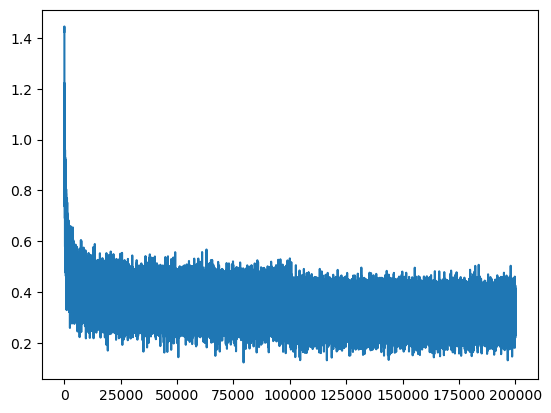

In [10]:
plt.plot(lossi)

In [6]:
# See Makemore #2. We did this before but it's refactored here for convenience:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]    # That's a switch (never seen it like this!)
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

    return loss

# split_loss('train')
# split_loss('val')

In [12]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # Forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # Sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # Shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # As soon as we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # Decode and print the generated word

mora.
mayanneeel.
nihayla.
remerstendraeg.
azeer.
melii.
shy.
jen.
eden.
esmanar.
katelos.
karin.
shubergahiriel.
kindreeller.
nohana.
uberted.
ryyah.
fael.
yuma.
myskella.


## Problem 1: Unrealisticly high initial loss

The probability of our model to predict the right and wrong char are same at the start  
Therefore, loss i log(1/27)

In [7]:
## We use negative log likelihood as the loss function
nll = -(torch.log(torch.tensor(1 / 27)))

In [8]:
nll

tensor(3.2958)

The above was the expected loss but ours was much much higher

In [9]:
logits = torch.tensor([[-8.0, 1.0, 4.0, 16.0]])
probs = torch.softmax(logits, dim=0)
loss = F.cross_entropy(logits, torch.tensor([0]))
loss

tensor(24.0000)

The above loss is high because the model don't have any idea that the values are equally likely

In [10]:
probs

tensor([[1., 1., 1., 1.]])

Because the logits are allowed to initially take on such a variety of values, it is unlikely for the NN to quickly learn a good combination of logits that reduces the loss.

We want the logits to be around 0 when we initialize the NN.
Theoretically, the logits could also be chosen around any number.
But, by default, we do this with  0  as the center so that we initialize closely to the range of the normal distribution.

So the question is: How do we get the logits of the output layer to be initially close to  0 ?

Solution: We scale  W2  to be close to  0  and turn off  b2  by setting it to  0 .

In [35]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0 # Initialize to 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [36]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


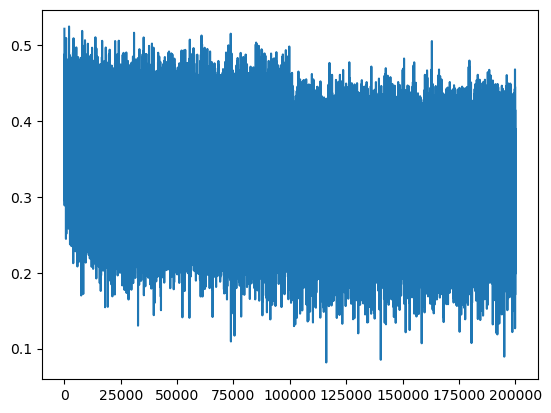

In [37]:
plt.plot(lossi)

Now the loss doesn't have that steep curve there as teh logits are not falsly confident about the results

In [38]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]                            # switch statement
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310744285583496


## Problem 2: Tanh Extrema

In [39]:
print(h.shape)
print(h.view(-1).shape)

torch.Size([32, 200])
torch.Size([6400])


tensor([[ 0.7100, -0.7878, -0.7423,  ..., -1.0000,  1.0000,  1.0000],
        [-0.5614, -1.0000, -1.0000,  ..., -0.8078,  0.9971, -0.9209],
        [-1.0000,  0.9940, -1.0000,  ...,  0.3852, -0.9303,  0.3263],
        ...,
        [-0.9992, -1.0000, -0.9999,  ..., -0.4351, -0.8976, -0.3768],
        [ 0.9939,  0.8976,  1.0000,  ..., -0.9538, -1.0000,  0.9987],
        [-1.0000, -0.9995, -1.0000,  ..., -0.6406, -0.8208,  0.5100]],
       grad_fn=<TanhBackward0>) 



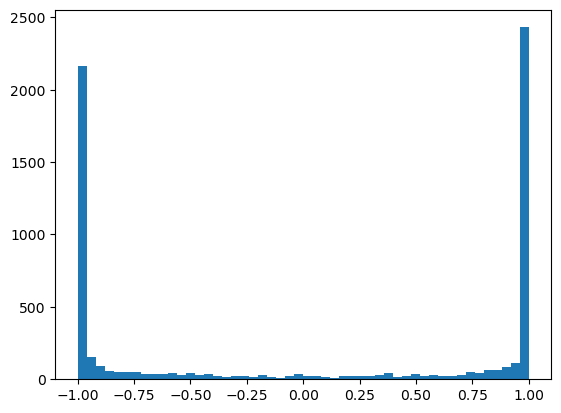

In [40]:
print(h, "\n") # hidden layer activations (32 x 200)
plt.hist(h.view(-1).tolist(), 50); # (6400 x 1), convert tensor to list, show histogram on distribution for 50 bins

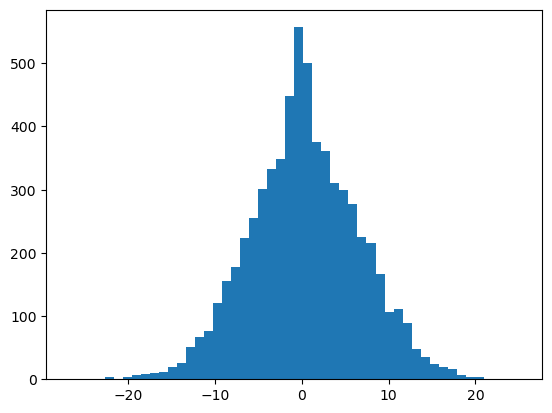

In [41]:
plt.hist(hpreact.view(-1).tolist(), 50);

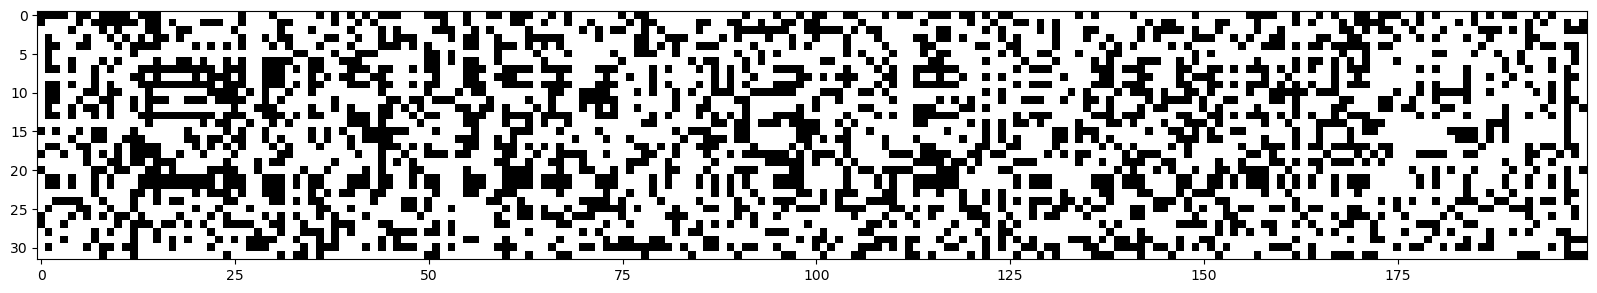

In [42]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [69]:
## make the ssame changes we did before squash the values of the parameters

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2  ## small but not zero
b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [116]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(42)
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1  # Small, but not 0
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # Small, but not 0 bias
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [117]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    #forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backwardd pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % (max_steps / 10) == 0:
        print(f"{i}/{max_steps}   {loss.item()}")

    break

0/200000   3.290677070617676


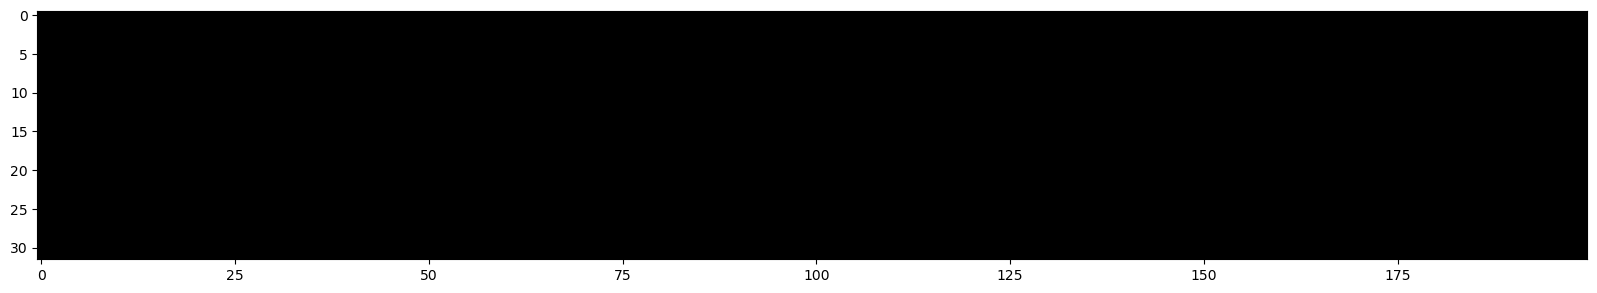

In [118]:
# We actually allow some to reach extremes, but its now rarely the case
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99 , cmap='gray', interpolation='nearest'); # true: white, false: black

tensor([[ 0.4562, -0.9091,  0.0342,  ...,  0.3244, -0.4553,  0.3526],
        [ 0.4986,  0.2121,  0.5500,  ..., -0.0167,  0.3492,  0.6353],
        [ 0.2918,  0.2332, -0.2780,  ...,  0.4783,  0.1764,  0.4186],
        ...,
        [-0.4485,  0.6287, -0.2276,  ..., -0.4807, -0.2322,  0.0969],
        [-0.8102,  0.5325, -0.8173,  ...,  0.4235,  0.2422,  0.3337],
        [ 0.6807,  0.8683, -0.0183,  ..., -0.8619, -0.4508, -0.8861]],
       grad_fn=<TanhBackward0>) 



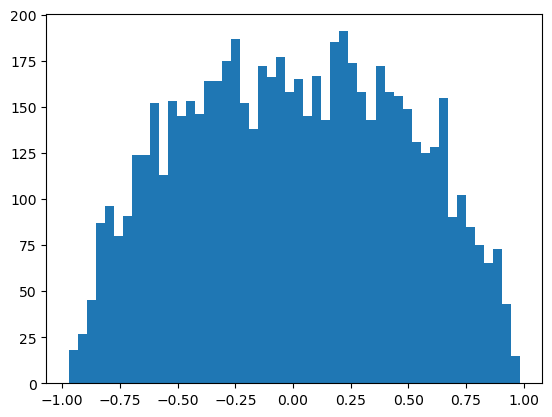

In [119]:
print(h, "\n")
plt.hist(h.view(-1).tolist(), 50);

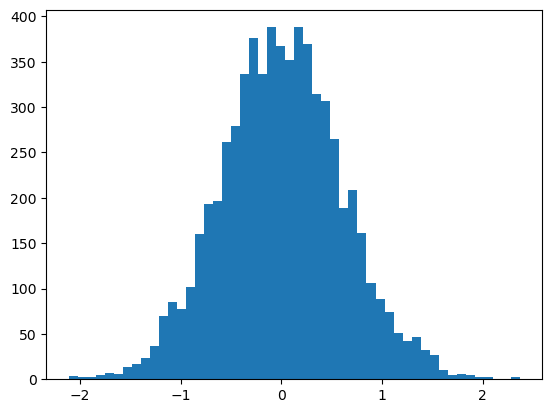

In [120]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [121]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.2757
  10000/ 200000: 1.8681
  20000/ 200000: 1.9424
  30000/ 200000: 2.1672
  40000/ 200000: 2.2394
  50000/ 200000: 2.2379
  60000/ 200000: 2.1330
  70000/ 200000: 2.3479
  80000/ 200000: 2.2356
  90000/ 200000: 2.3857
 100000/ 200000: 2.1209
 110000/ 200000: 1.9910
 120000/ 200000: 2.0612
 130000/ 200000: 2.3894
 140000/ 200000: 1.9982
 150000/ 200000: 2.3133
 160000/ 200000: 2.1461
 170000/ 200000: 2.0426
 180000/ 200000: 1.9470
 190000/ 200000: 2.0885


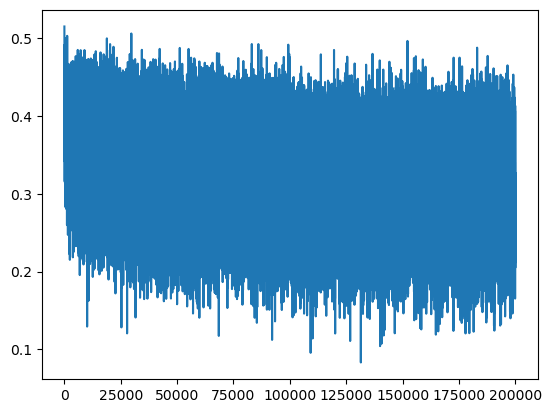

In [122]:
plt.plot(lossi);

In [123]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.05678129196167
val 2.1114611625671387


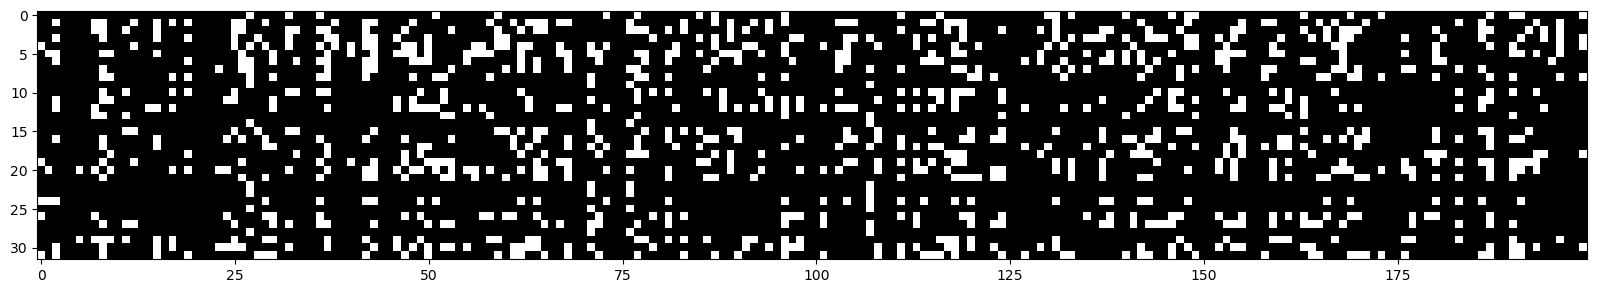

In [124]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest')

## Problem 1 + 2 : Weight + Bias scaling

Well ... we now have a lot of "magic numbers", the factors for the weights and biases:

```
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0
```

**How do you determine and set these values for large multilayer MLPs?**

X: tensor(-0.0119) tensor(0.9930)
W: tensor(0.0197) tensor(1.0066)
Y: tensor(0.0107) tensor(3.1597)


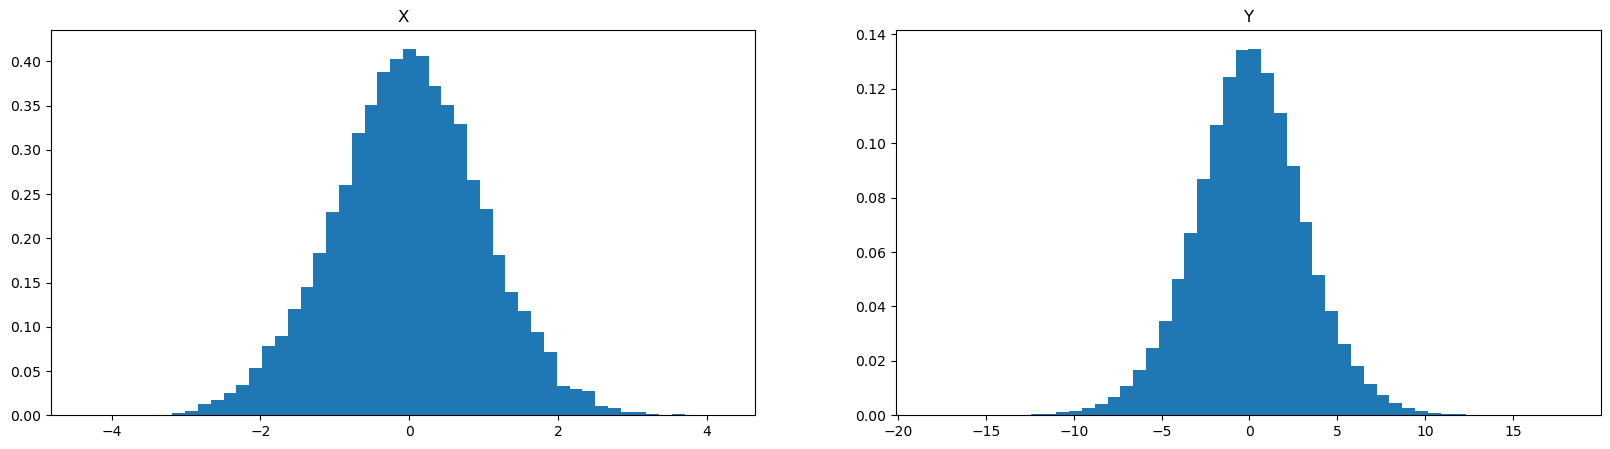

In [125]:
x = torch.randn(1000, 10) # 1000 vectors á 10 dimensions (inputs) (gaussian-distributed)
w = torch.randn(10, 200)  # 10 vectors á 200 dimensions (200 neurons, each looking at 10 inputs)

# [!] We leave out the biases b for this example

y = x @ w # Get the neurons pre-activations

print('X:', x.mean(), x.std())  # mean ~0, standard dev: ~1 (as this is Gaussian)
print('W:', w.mean(), w.std())  # mean ~0, standard dev: ~1 (also Gaussian)
print('Y:', y.mean(), y.std())  # mean ~0, standard dev: ~3 ?!

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('X')
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.title('Y')
plt.hist(y.view(-1).tolist(), 50, density=True);

X: tensor(-4.7463e-05) tensor(0.9972)
W: tensor(-0.0047) tensor(0.3147)
Y: tensor(-0.0017) tensor(0.9948)


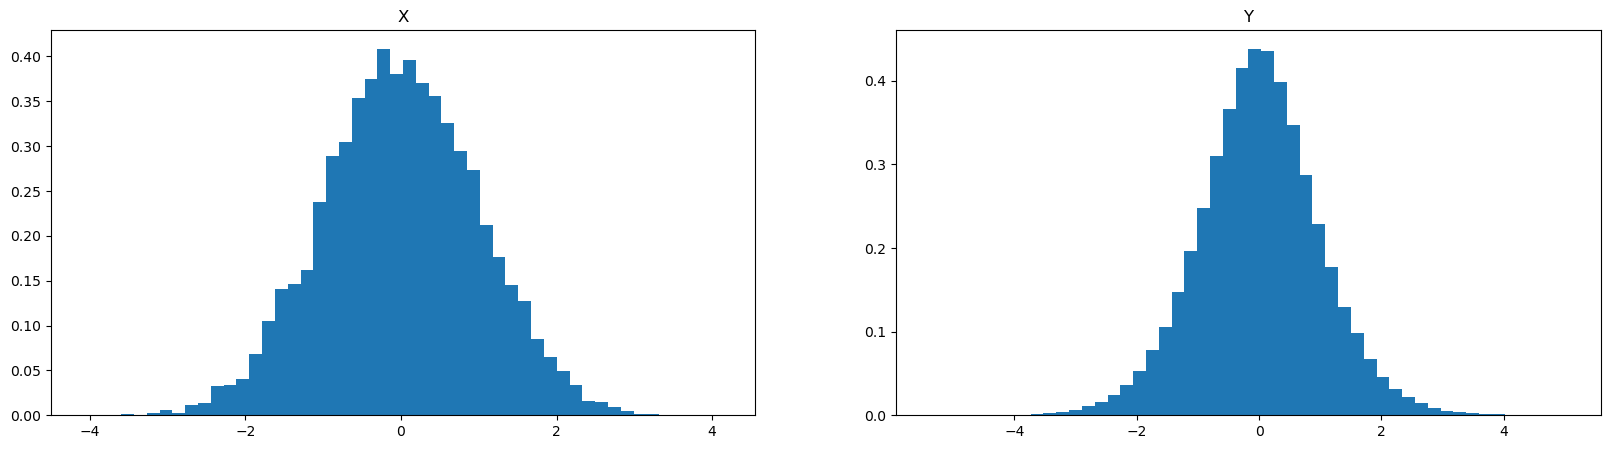

In [126]:
x = torch.randn(1000, 10) 
w = torch.randn(10, 200) * 10**-0.5 # meaning / sqrt(10) or 0.316228

y = x @ w

print('X:', x.mean(), x.std())
print('W:', w.mean(), w.std())
print('Y:', y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('X')
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.title('Y')
plt.hist(y.view(-1).tolist(), 50, density=True);

In [127]:
n_embd = 10
n_hidden = 200

g  = torch.Generator().manual_seed(2147483647)
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Here (5/3) is gain given for tanh in pytorch
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # the factor makes the std of the output ~1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # Small, but not 0
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Small, but not 0
b2 = torch.randn(vocab_size,                      generator=g) * 0    # Biases are now all 0

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

In [128]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9751
 190000/ 200000: 1.8614


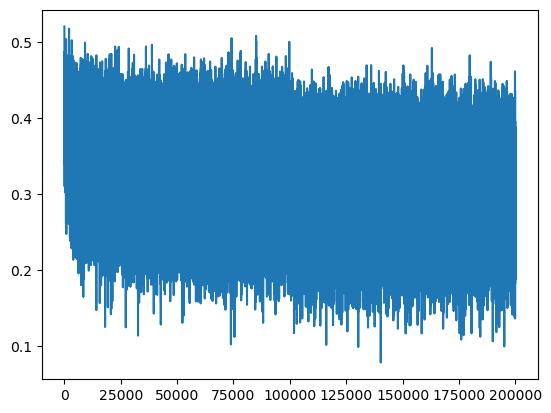

In [129]:
plt.plot(lossi);

In [130]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x]                          # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)
    
    h = torch.tanh(embcat @ W1 + b1)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376646518707275
val 2.1069893836975098


| Losses    | Original  | Solved Problem (1) | Solved Problem (2) | Solved Problem (1+2) |
| --------- | --------- | ------------------ | ------------------ | -------------------- |
| **Train** | 2.1270018 | 2.0695891          | **2.0355966**      | 2.0376642            |
| **Val**   | 2.1699057 | 2.1310747          | **2.1026785**      | 2.1069896            |

We end up roughly where we started. This is actually a good thing, because we no longer have a "magic number" that scales our weights.<br>
We simply calculated the scaling factor we are now using.